In [ ]:
# release
# ==============================================================================
# There are 5 questions in this exam with increasing difficulty from 1-5.
# Please note that the weight of the grade for the question is relative to its
# difficulty. So your Category 1 question will score significantly less than
# your Category 5 question.
#
# WARNING: Do not use lambda layers in your model, they are not supported
# on the grading infrastructure. You do not need them to solve the question.
#
# WARNING: If you are using the GRU layer, it is advised not to use the
# recurrent_dropout argument (you can alternatively set it to 0),
# since it has not been implemented in the cuDNN kernel and may
# result in much longer training times.
#
# WARNING: Input and output shape requirements are laid down in the section 
# 'INSTRUCTIONS' below and also reiterated in code comments. 
# Please read them thoroughly. After submitting the trained model for scoring, 
# if you are receiving a score of 0 or an error, please recheck the input and 
# output shapes of the model to see if it exactly matches our requirements. 
# Grading infrastrcuture is very strict about the shape requirements. Most common 
# issues occur when the shapes are not matching our expectations.
#
# TIP: You can print the output of model.summary() to review the model
# architecture, input and output shapes of each layer.
# If you have made sure that you have matched the shape requirements
# and all the other instructions we have laid down, and still
# receive a bad score, you must work on improving your model.
#
# You must use the Submit and Test button to submit your model
# at least once in this category before you finally submit your exam,
# otherwise you will score zero for this category.
# ==============================================================================
#
# TIME SERIES QUESTION
#
# Build and train a neural network to predict time indexed variables of
# the multivariate house hold electric power consumption time series dataset.
# Using a window of past 24 observations of the 7 variables, the model
# should be trained to predict the next 24 observations of the 7 variables.
#
# ==============================================================================
#
# ABOUT THE DATASET
#
# Original Source:
# https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
#
# The original Individual House Hold Electric Power Consumption Dataset
# has Measurements of electric power consumption in one household with
# a one-minute sampling rate over a period of almost 4 years.
#
# Different electrical quantities and some sub-metering values are available.
#
# For the purpose of the examination we have provided a subset containing
# the data for the first 60 days in the dataset. We have also cleaned the
# dataset beforehand to remove missing values. The dataset is provided as a
# CSV file in the project.
#
# The dataset has a total of 7 features ordered by time.
# ==============================================================================
#
# INSTRUCTIONS
#
# Complete the code in following functions:
# 1. solution_model()
#
# You may receive a score of 0 or your code will fail to be graded if the 
# following criteria are not met:
#
# 1. Model input shape must be (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7),
#    since the testing infrastructure expects a window of past N_PAST = 24
#    observations of the 7 features to predict the next N_FUTURE = 24
#    observations of the same features.
#
# 2. Model output shape must be (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7)
#
# 3. The last layer of your model must be a Dense layer with 7 neurons since
#    the model is expected to predict observations of 7 features.
#
# 4. Don't change the values of the following constants:
#    SPLIT_TIME, N_FEATURES, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT, in
#    solution_model() (See code for additional note on BATCH_SIZE).
#
# 5. Code for normalizing the data is provided - don't change it.
#    Changing the normalizing code will affect your score.
#
# 6. Code for converting the dataset into windows is provided - don't change it.
#    Changing the windowing code will affect your score.
#
# 7. Code for setting the seed is provided - don't change it.
#
# Make sure that the model architecture and input, output shapes match our
# requirements by printing model.summary() and reviewing its output.
#
# HINT: If you follow all the rules mentioned above and throughout this
# question while training your neural network, there is a possibility that a
# validation MAE of approximately 0.055 or less on the normalized validation
# dataset may fetch you top marks.


import urllib
import zipfile

import pandas as pd
import tensorflow as tf


# This function downloads and extracts the dataset to the directory that
# contains this file.
# DO NOT CHANGE THIS CODE
# (unless you need to change https to http)
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [ ]:


# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data


# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and
# validation. First element of the first window will be the first element of
# the dataset. Consecutive windows are constructed by shifting
# the starting position of the first window forward, one at a time (indicated
# by shift=1). For a window of n_past number of observations of all the time
# indexed variables in the dataset, the target for the window
# is the next n_future number of observations of these variables, after the
# end of the window.

# DO NOT CHANGE THIS CODE
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)



# This function loads the data from CSV file, normalizes the data and
# splits the dataset into train and validation data. It also uses
# windowed_dataset() to split the data into windows of observations and
# targets. Finally it defines, compiles and trains a neural network. This
# function returns the final trained model.

In [ ]:

# COMPLETE THE CODE IN THIS FUNCTION
# Downloads and extracts the dataset to the directory that
# contains this file.
download_and_extract_data()
# Reads the dataset from the CSV.
df = pd.read_csv('household_power_consumption.csv', sep=',',
                 infer_datetime_format=True, index_col='datetime', header=0)

# Number of features in the dataset. We use all features as predictors to
# predict all features at future time steps.
N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

# Normalizes the data
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

# Splits the data into training and validation sets.
SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

# DO NOT CHANGE THIS CODE
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
# THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
# In other cases, it is advised not to change the batch size since it
# might affect your final scores. While setting it to a lower size
# might not do any harm, higher sizes might affect your scores.
BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

# DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
# on the server.
# Number of past time steps based on which future observations should be
# predicted
N_PAST = 24  # DO NOT CHANGE THIS

# Number of future time steps which are to be predicted.
N_FUTURE = 24  # DO NOT CHANGE THIS

# By how many positions the window slides to create a new window
# of observations.
SHIFT = 1  # DO NOT CHANGE THIS

# Code to create windowed train and validation datasets.
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                             n_past=N_PAST, n_future=N_FUTURE,
                             shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                             n_past=N_PAST, n_future=N_FUTURE,
                             shift=SHIFT)

In [73]:
from tensorflow.keras.layers import LSTM

def create_uncompiled_model():
    # Code to define your model.
    model = tf.keras.models.Sequential([
    
        # ADD YOUR LAYERS HERE.
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=(N_PAST, N_FEATURES)),
        #     tf.keras.layers.Conv1D(30, kernel_size=6, padding='causal', activation='relu'),
            tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
        
        
        
        #   tf.keras.layers.Conv1D(filters=64, kernel_size=3,
        #                   strides=1,
        #                   activation="relu",
        #                   padding='causal',
        #                   input_shape=(N_PAST, N_FEATURES)),
        #     tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        #     tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        #     tf.keras.layers.LSTM(64, return_sequences=True, ),
        #     tf.keras.layers.LSTM(64, return_sequences=True),
        #     tf.keras.layers.Dense(30, activation="relu"),
        #     tf.keras.layers.Dense(10, activation="relu"),
        
    
        # If you don't follow the instructions in the following comments,
        # tests will fail to grade your code:
        # The input layer of your model must have an input shape of:
        # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)
        # The model must have an output shape of:
        # (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7).
        # Make sure that there are N_FEATURES = 7 neurons in the final dense
        # layer since the model predicts 7 features.
    
        # HINT: Bidirectional LSTMs may help boost your score. This is only a
        # suggestion.
    
        # WARNING: After submitting the trained model for scoring, if you are
        # receiving a score of 0 or an error, please recheck the input and 
        # output shapes of the model to see if it exactly matches our requirements. 
        # The grading infrastructure is very strict about the shape requirements. 
        # Most common issues occur when the shapes are not matching our 
        # expectations.
        #
        # TIP: You can print the output of model.summary() to review the model
        # architecture, input and output shapes of each layer.
        # If you have made sure that you have matched the shape requirements
        # and all the other instructions we have laid down, and still
        # receive a bad score, you must work on improving your model.
    
        # WARNING: If you are using the GRU layer, it is advised not to use the
        # recurrent_dropout argument (you can alternatively set it to 0),
        # since it has not been implemented in the cuDNN kernel and may
        # result in much longer training times.
        tf.keras.layers.Dense(N_FEATURES)
    ])
    return model


In [74]:
model = create_uncompiled_model()
model.summary()

# Code to train and compile the model
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# loss = tf.keras.losses.MSE()
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 24, 64)            1408      
                                                                 
 bidirectional_11 (Bidirect  (None, 24, 128)           66048     
 ional)                                                          
                                                                 
 lstm_44 (LSTM)              (None, 24, 60)            45360     
                                                                 
 lstm_45 (LSTM)              (None, 24, 60)            29040     
                                                                 
 dense_46 (Dense)            (None, 24, 32)            1952      
                                                                 
 dense_47 (Dense)            (None, 24, 16)            528       
                                                     

In [75]:
model_name = 'bidirectional_2x_lstm'

earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'ckpts/{model_name}-'+'{epoch:02d}-{val_mae:.4f}')

history = model.fit(train_set, epochs=20, validation_data=valid_set)

# Note that you'll need to save your model as a .h5 like this.
# When you press the Submit and Test button, your saved .h5 model will
# be sent to the testing infrastructure for scoring
# and the score will be returned to you.


Epoch 1/20
1349/1349 [==============================] - 29s 17ms/step - loss: 0.0217 - mae: 0.0859 - val_loss: 0.0157 - val_mae: 0.0665
Epoch 2/20
  11/1349 [..............................] - ETA: 14s - loss: 0.0120 - mae: 0.0653

2024-05-21 17:54:24.122548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1219231678715670512


1349/1349 [==============================] - 21s 16ms/step - loss: 0.0191 - mae: 0.0786 - val_loss: 0.0157 - val_mae: 0.0681
Epoch 3/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0169 - mae: 0.0733 - val_loss: 0.0158 - val_mae: 0.0677
Epoch 4/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0167 - mae: 0.0727 - val_loss: 0.0155 - val_mae: 0.0663
Epoch 5/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0165 - mae: 0.0719 - val_loss: 0.0155 - val_mae: 0.0671
Epoch 6/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0165 - mae: 0.0720 - val_loss: 0.0155 - val_mae: 0.0671
Epoch 7/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0164 - mae: 0.0717 - val_loss: 0.0154 - val_mae: 0.0671
Epoch 8/20
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0181 - mae: 0.0753 - val_loss: 0.0154 - val_mae: 0.0668
Epoch 9/20
1349/1349 [==============================] - 21s

In [76]:
model.save(f'models/{model_name}-{len(history.epoch)}-{history.history["val_mae"][-1]:.4f}.h5')
save_history(history, f'models/{model_name}-{len(history.epoch)}-{history.history["val_mae"][-1]:.4f}')

In [82]:
loaded_model = tf.keras.models.load_model(f'models/{model_name}-20-0.0615.h5')
loaded_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 24, 64)            1408      
                                                                 
 bidirectional_11 (Bidirect  (None, 24, 128)           66048     
 ional)                                                          
                                                                 
 lstm_44 (LSTM)              (None, 24, 60)            45360     
                                                                 
 lstm_45 (LSTM)              (None, 24, 60)            29040     
                                                                 
 dense_46 (Dense)            (None, 24, 32)            1952      
                                                                 
 dense_47 (Dense)            (None, 24, 16)            528       
                                                     

In [ ]:
# Continue training the loaded model starting from the initial_epoch
hist = loaded_model.fit(train_set, epochs=20, validation_data=valid_set, initial_epoch=20)

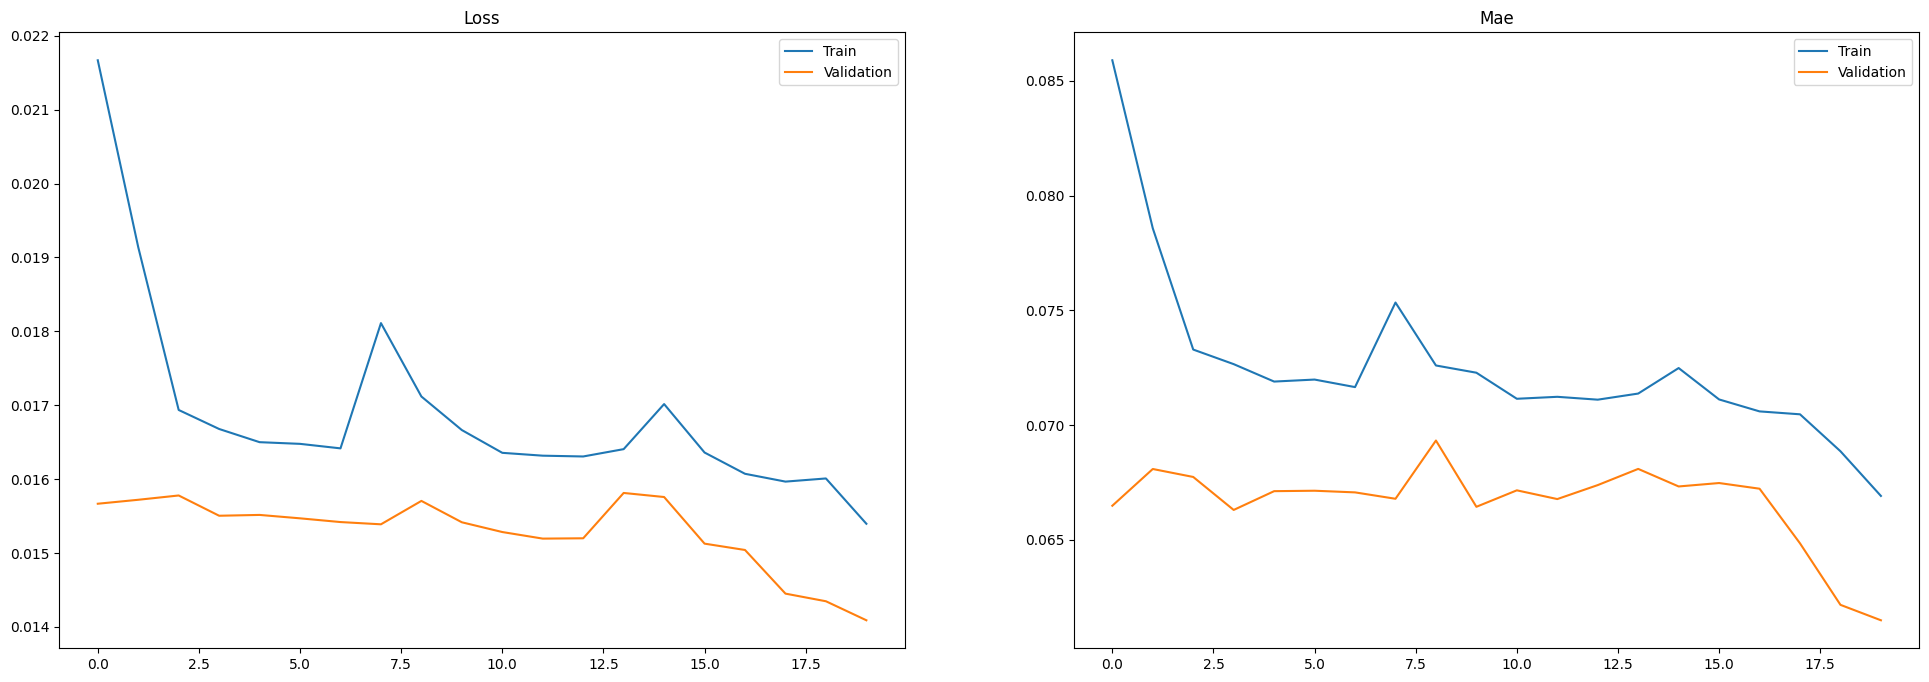

In [78]:
from history import plot_history
plot_history(history)

In [79]:
model.save("mymodel.h5")


In [80]:
import numpy as np
# THIS CODE IS USED IN THE TESTER FOR FORECASTING. IF YOU WANT TO TEST YOUR MODEL
# BEFORE UPLOADING YOU CAN DO IT WITH THIS
def mae(y_true, y_pred):
   return np.mean(abs(y_true.ravel() - y_pred.ravel()))


def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast


# PASS THE NORMALIZED data IN THE FOLLOWING CODE

rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :]

x_valid = x_valid[:rnn_forecast.shape[0]]
result = mae(x_valid, rnn_forecast)

result


2699/2699 [==============================] - 13s 5ms/step


0.05262850329311197